<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#General-parameters" data-toc-modified-id="General-parameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>General parameters</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Functions</a></span></li></ul></li><li><span><a href="#The-example" data-toc-modified-id="The-example-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The example</a></span></li><li><span><a href="#The-plot" data-toc-modified-id="The-plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>The plot</a></span></li></ul></div>

# Preamble

In [1]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns



from network import Protocol, Network, NetworkManager
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

## General parameters

In [2]:
%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

epsilon = 1e-7
vmin = -3.0
remove = 0.010

strict_maximum = True

dt = 0.001
tau_s = 0.010
tau_a = 0.250
g_I = 1.0
g_a = 2.0
G = 50.0

sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['figure.figsize'] = (12, 8)
lw = 10
ms = 22
alpha_graph = 0.3
colors = sns.color_palette()

## Functions

# The example

CPU times: user 36 ms, sys: 12 ms, total: 48 ms
Wall time: 40.5 ms


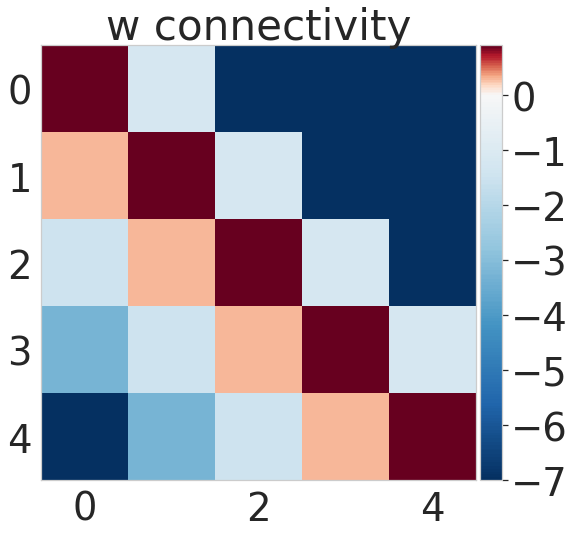

In [3]:
%%time

sigma_out = 0.0
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 5
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.500
epochs = 1
T_persistence = 0.100

# Manager properties
values_to_save = ['o', 'i', 'z_pre', 's', 'a', 'beta']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)
plot_weight_matrix(manager)

pattern sequence [0, 1, 2, 3, 4]
times [0.099, 0.105, 0.105, 0.105, 0.109]
T_calculated 0.105


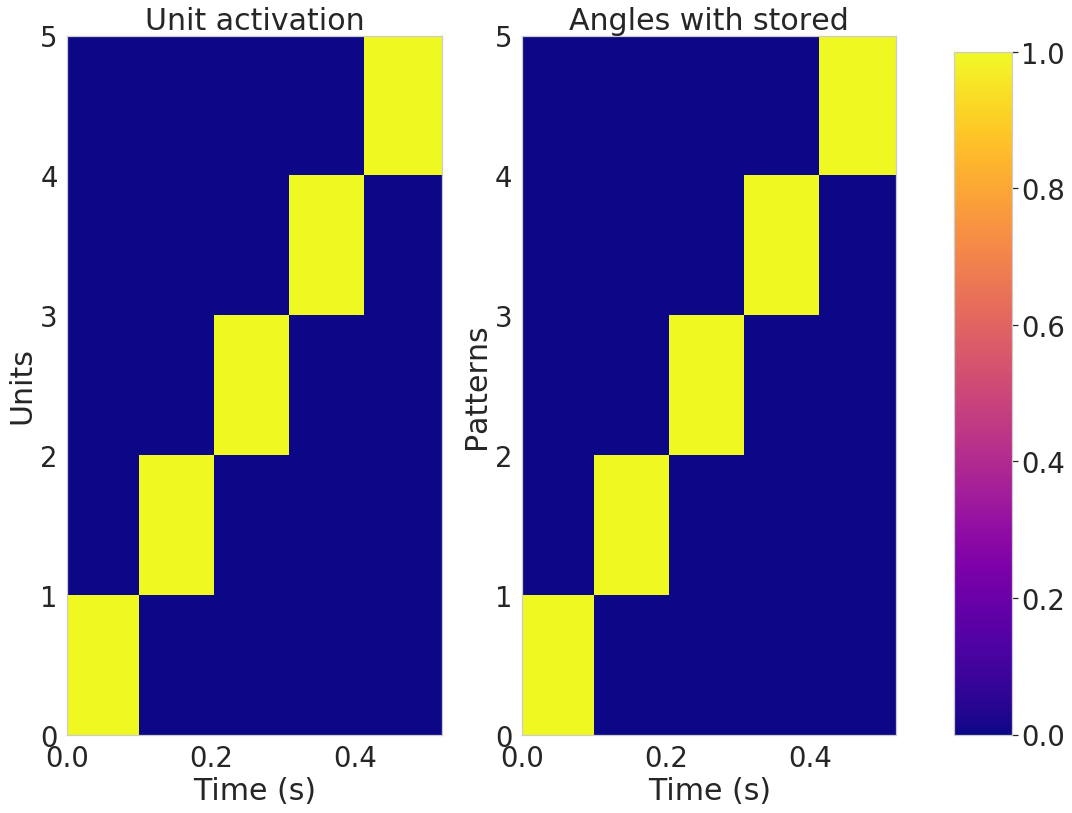

In [7]:
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, from_state=1, to_state=2)

T_cue = 1.0 * manager.nn.tau_s
T_recall = 1.0 * T_persistence * n_patterns + T_cue
manager.nn.z_pre[0] = 1.0

# Success
nr = representation.network_representation
aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success, pattern_sequence, persistent_times, timings = aux

print('pattern sequence', pattern_sequence)
print('times', persistent_times)
print('T_calculated', np.mean(persistent_times[1:-1]))
plot_network_activity_angle(manager, time_y=False);

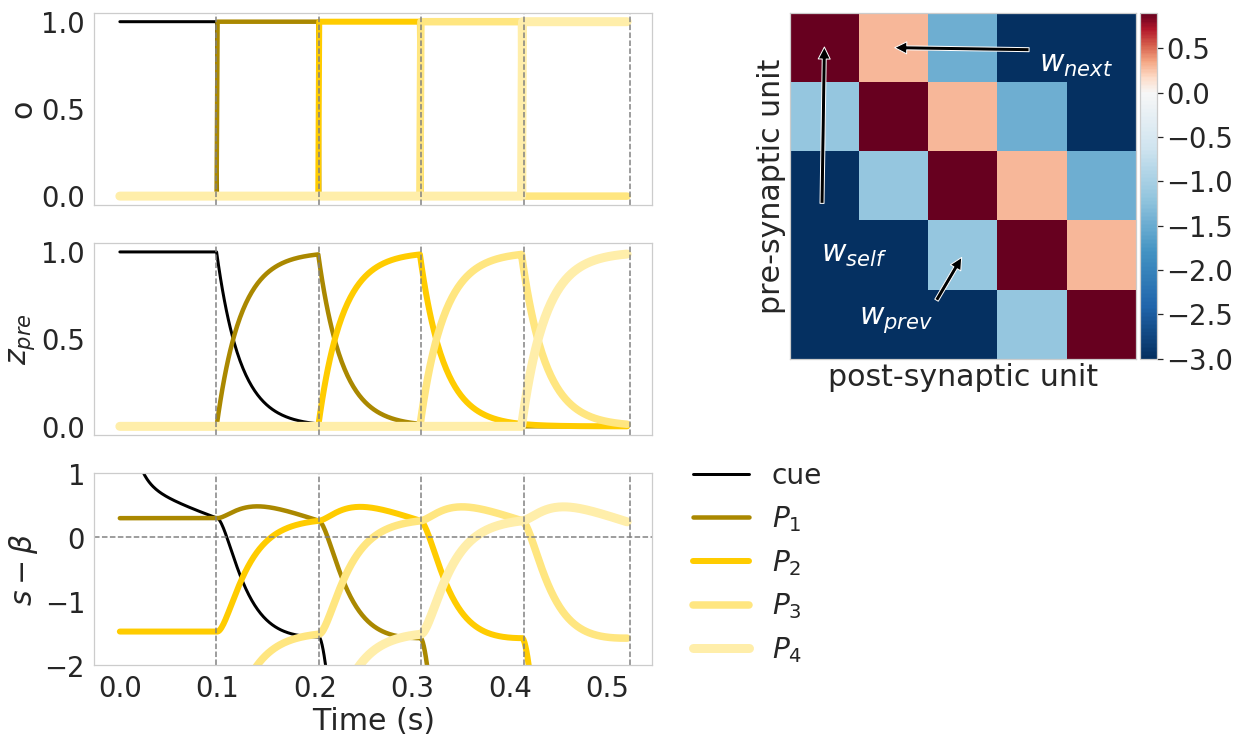

In [36]:
I = manager.history['i']
O = manager.history['o']
Z_pre = manager.history['z_pre']
S = manager.history['s']
A = manager.history['a']
Beta = manager.history['beta']

sns.set(font_scale=2.5)
sns.set_style("whitegrid", {'axes.grid': False})

colors = ['black', '#aa8800ff', '#ffcc00ff', '#ffe680ff', '#ffeeaaff']
legend = ['cue', r'$P_1$', r'$P_2$', r'$P_3$', r'$P_4$']

gs = gridspec.GridSpec(3, 2)
fig = plt.figure(figsize=(22, 12))


ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])

lw = 1.5
for index in range(n_patterns):
    lw += 1.5
    ax1.plot(manager.time, O[:, index], lw=lw, color=colors[index], label=legend[index])
    ax2.plot(manager.time, Z_pre[:, index], lw=lw, color=colors[index])
    #ax3.plot(manager.time, I[:, index] - manager.nn.g_a * A[:, index], lw=lw, color=colors[index])
    ax3.plot(manager.time, S[:, index] - Beta[:, index], lw=lw, color=colors[index])

ax3.set_ylim([-2.0, 1.0])

ax3.axhline(0, ls='--', color='gray')

ax3.set_xlabel('Time (s)')
ax1.set_ylabel('o')
ax2.set_ylabel(r'$z_{pre}$')
ax3.set_ylabel(r'$s - \beta$')

ax1.tick_params(axis='x', which='both', labelbottom=False)
ax2.tick_params(axis='x', which='both', labelbottom=False)

aux_t = 0
for T_per in persistent_times:
    aux_t += T_per
    ax1.axvline(aux_t, ls='--', color='gray')
    ax2.axvline(aux_t, ls='--', color='gray')
    ax3.axvline(aux_t, ls='--', color='gray')

# Here we plot our connectivity matrix
rect = [0.48, 0.48, 0.40, 0.40]
# ax_conn = fig.add_subplot(gs[:2, 1])
ax_conn = fig.add_axes(rect)

ax_conn = plot_weight_matrix(manager, ax=ax_conn, vmin=vmin, title=False, transpose=True)
ax_conn.set_xlabel('post-synaptic unit')
ax_conn.set_ylabel('pre-synaptic unit')

ax_conn.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)

# cbar = im[-1].colorbar
#cbar.set_ticks([-1, 0, 1])
# cbar.set_ticklabels([-1, 0, 1])
annotations = True
arrow_color = 'black'
if annotations:
    letter_color = 'white'
    ax_conn.annotate(r'$w_{self}$', xy=(0, -0.5), xytext=(-0.05, 3.1), color=letter_color,
                     arrowprops=dict(facecolor=arrow_color, shrink=0.15))

    ax_conn.annotate(r'$w_{next}$', xy=(0.9, 0), xytext=(3.1, 0.35), color=letter_color,
                arrowprops=dict(facecolor=arrow_color, shrink=0.05))

    #ax_conn.annotate(r'$w_{rest}$', xy=(4.9, 3.0), xytext=(6.8, 3.5), color=letter_color,
    #            arrowprops=dict(facecolor=arrow_color, shrink=0.05))

    ax_conn.annotate(r'$w_{prev}$', xy=(2, 3), xytext=(0.5, 4.0), color=letter_color,
                arrowprops=dict(facecolor=arrow_color, shrink=0.05))

# Let's plot our legends
# ax_legend = fig.add_subplot(gs[2, 1])
# lines = ax1.get_lines()
handles, labels = ax1.get_legend_handles_labels()
# ax_legend.legend(ax1.get_legend_handles_labels())

fig.legend(handles=handles, labels=labels, loc=(0.55, 0.09), fancybox=True, frameon=False, facecolor=(0.0, 0.0, 0.0),
           fontsize=28, ncol=1)

directory = '../plot_producers/'
file_name = 'recall_example' 
format_string = '.svg'
string_to_save = directory + file_name + format_string
fig.savefig(string_to_save, frameon=False, dpi=1000, bbox_inches='tight', transparent=True)

# The plot

In [ ]:
np.where(nr[0])[0]

In [ ]:
nn.z_pre

In [ ]:
nn.z_pre[np.where(nr[0])[0]] = 1

In [ ]:
nn.z_pre